# SN10 classifier and integrated gradients attribution

In this notebook, we develop the SN10 classifier used in `Absolut!` and the integrated-gradients method of attribution. We might also check other attribution methods.

In [1]:
import os
from pathlib import Path
from typing import List

import pandas as pd
import numpy as np
import seaborn as sns
import joypy

import torch
from torch import nn
from torch.utils.data import DataLoader
from captum.attr import IntegratedGradients

import NegativeClassOptimization.config as config
import NegativeClassOptimization.preprocessing as preprocessing
from NegativeClassOptimization.ml import (
    PairwiseDataset, preprocess_data_for_pytorch_pairwise, 
    SN10, 
    train_loop, test_loop, 
    compute_integratedgradients_attribution
)

/home/eugen/miniconda3/envs/ab-negative-training/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's load the data on which we are going to develop the binary classifier.

In [2]:
df = pd.read_csv(config.DATA_SLACK_1_GLOBAL, sep='\t')

ag_pos = "3VRL"
ag_neg = "1ADQ"
df = df.loc[df["Antigen"].isin([ag_pos, ag_neg])].copy()

df.head(2)

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,UID,Antigen
0,1873658_06a,CARPENLLLLLWYFDVW,True,LLLLLWYFDVW,-112.82,137442-BRDSLLUDLS,3VRL_1873658_06a,3VRL
1,7116990_04a,CARGLLLLLWYFDVW,True,LLLLLWYFDVW,-112.82,137442-BRDSLLUDLS,3VRL_7116990_04a,3VRL


First, handle duplicates.

In [3]:
train_data, test_data, train_loader, test_loader = preprocess_data_for_pytorch_pairwise(df, ag_pos)

,Slide,Antigen,Slide_onehot,X,y
0,AAELFWYFDVW,3VRL,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,AAFITTVGWYF,1ADQ,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,AAFYGRWYFDV,1ADQ,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


Setup the model.

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = SN10().to(device)
print(model)

Using cpu device
SN10(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=220, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


Setup and run optimization.

In [6]:
learning_rate = 0.01
epochs = 5
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)

Epoch 1
-------------------------------
loss: 0.723419  [    0/66571]
loss: 0.684601  [ 6400/66571]
loss: 0.658798  [12800/66571]
loss: 0.653108  [19200/66571]
loss: 0.591406  [25600/66571]
loss: 0.650025  [32000/66571]
loss: 0.602729  [38400/66571]
loss: 0.515426  [44800/66571]
loss: 0.510487  [51200/66571]
loss: 0.478343  [57600/66571]
loss: 0.513641  [64000/66571]
Test Error: 
 Accuracy: 81.2%, Avg loss: 0.476355 

Epoch 2
-------------------------------
loss: 0.471044  [    0/66571]
loss: 0.419002  [ 6400/66571]
loss: 0.370769  [12800/66571]
loss: 0.463803  [19200/66571]
loss: 0.410664  [25600/66571]
loss: 0.486013  [32000/66571]
loss: 0.370902  [38400/66571]
loss: 0.359683  [44800/66571]
loss: 0.367171  [51200/66571]
loss: 0.346467  [57600/66571]
loss: 0.374388  [64000/66571]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.363028 

Epoch 3
-------------------------------
loss: 0.386108  [    0/66571]
loss: 0.326159  [ 6400/66571]
loss: 0.245498  [12800/66571]
loss: 0.371860  [19200/665

Having trained a model, we explore integrated gradients as an attribution method. As baseline, we use the zero one-hot tensor. 

Computing integrated gradients for feature $i$:

$$\text{IntegratedGrads}_i^{approx}(x) = (x_i-x_i') \cdot \frac{1}{m} \cdot \sum_{k=1}^{m}\frac{\partial F(x'+\frac{k}{m}\cdot (x-x'))}{\partial x_i}$$

Essential for the implementation is computing:

$$\frac{\partial F(x'+\frac{k}{m}\cdot (x-x'))}{\partial x_i}, \text{ where }F(x)\text{ is the SN10}$$

One issue concerns the baseline. I'm not sure a zero-valued one-hot vector is the relevant baseline. I should maybe try different baselines (such as different aminoacids, or some specific sequence). Also, Euclidian interpolation might not be relevant as well.

In any case, [Captum](https://captum.ai/) provides implementations for many interpretability methods. It looks like it also has interpretability methods for NLP models. It also has [a useful section](https://captum.ai/docs/algorithms_comparison_matrix) that compares algorithms.

For first, let's go with integrated gradients and compute for all the test set. It would also be useful to add visualisation like [Captum Insights](https://captum.ai/tutorials/CIFAR_TorchVision_Captum_Insights).

In [ ]:
records = compute_integratedgradients_attribution(test_data, model)

In [16]:
attributions = list(map(lambda tupl: tupl[0].numpy(), records))

abs_sums = []
for attr in attributions:
    abs_sum = np.abs(attr.reshape((11, 20))).sum(axis=1)
    abs_sums.append(abs_sum)

df_attr = pd.DataFrame(data=np.stack(abs_sums), columns=range(1, 12))

In [21]:
attributions[0].reshape(-1).shape

(220,)

In [38]:
df_ext = pd.DataFrame(
    data=np.stack(map(lambda a: a.reshape(-1), attributions)), 
    columns=(
        f"{position} {aa}" 
        for position in range (1, 12) 
        for aa in config.AMINOACID_ALPHABET
    )
)

/home/eugen/miniconda3/envs/ab-negative-training/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


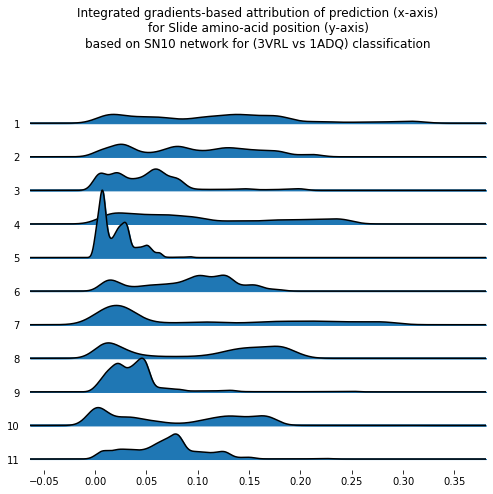

In [37]:
# joypy.joyplot(df_ext, figsize=(20, 15))
g = joypy.joyplot(
    df_attr,
    figsize=(7, 7),
    title="Integrated gradients-based attribution of prediction (x-axis)\nfor Slide amino-acid position (y-axis)\nbased on SN10 network for (3VRL vs 1ADQ) classification")